<a href="https://colab.research.google.com/github/comb0601/deepfake/blob/master/deepfake_1_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install mtcnn
!pip install facenet-pytorch
from google.colab.patches import cv2_imshow


import argparse
import glob
import os
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import skimage.measure
from skimage import measure
from facenet_pytorch import MTCNN
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#TEST_PATH = '/content/'
TRAIN_PATH = '/gdrive/My Drive/'

#metadata = '../input/deepfake-detection-challenge/train_sample_videos/metadata.json'

In [4]:
# load the filenames for train videos
train_fns = sorted(glob.glob(TRAIN_PATH + '*.mp4'))

# load the filenames for test videos
#test_fns = sorted(glob.glob(TEST_PATH + '*.mp4'))

print('There are {} samples in the train set.'.format(len(train_fns)))
#print('There are {} samples in the test set.'.format(len(test_fns)))

There are 2 samples in the train set.


In [5]:
train_fns

['/gdrive/My Drive/fake.mp4', '/gdrive/My Drive/real.mp4']

In [6]:
def get_frames(filename):
    '''
    Get all frames from the video
    INPUT:
        filename - video filename
    OUTPUT:
        frames - the array of video frames
    '''
    frames = []
    
    cap = cv2.VideoCapture(filename)
    
    #while(cap.isOpened()):
    while len(frames) < 301 :
        ret, frame = cap.read()
                
        if not ret:
            break;
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

    cap.release()
    cv2.destroyAllWindows()
    return frames



In [ ]:
# 얼굴 감지
# Create face detector
for video in train_fns[:1] :
  frames = get_frames(video)
  mtcnn = MTCNN(margin=20, keep_all=False, post_process=False,device='cuda:0')  #keep_all : multiple faces in a single image,device='cuda:0'

  
  save_paths = [str(video)+f'image_{i}.jpg' for i in range(len(frames[:100]))]
  mtcnn(frames[:100], save_path=save_paths)

  save_paths = [str(video)+f'image_{i}.jpg' for i in range(len(frames[100:200]))]
  mtcnn(frames[100:200], save_path=save_paths)

  save_paths = [str(video)+f'image_{i}.jpg' for i in range(len(frames[200:300]))]
  mtcnn(frames[200:300], save_path=save_paths)

# 새 섹션

In [ ]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

In [6]:

def edgeEntropy(image):
    edge = cv2.Canny(image, 50, 100)
    return skimage.measure.shannon_entropy(edge)

In [7]:
def edgeNoiseAnalysis(image):
    h, w = len(image), len(image[0])

    edge = cv2.Canny(image, 50, 130)

    base = cv2.getGaussianKernel(5, 5)
    kernel = np.outer(base, base.transpose())

    arr = cv2.filter2D(edge, -1, kernel)

    edgecount = 0
    arrcount = 0

    for i in range(w):
        for j in range(h):
            if arr[i][j] < 55:
                arr[i][j] = 0
            else:
                arr[i][j] = 255
                arrcount += 1

            if edge[i][j] == 255:
                edgecount += 1

    return (arrcount - edgecount) / edgecount * 100



In [8]:
def edgeDensityAnalysis(image):
    h, w = len(image), len(image[0])

    edge = cv2.Canny(image, 50, 130)

    total_slc = 0
    slc_include_edge = 0

    for i in range(w):
        for j in range(h):
            if edge[i][j] == 255:
                slc_include_edge += 1
            total_slc += 1

    return (slc_include_edge / total_slc) * 100

In [9]:
def totalVariance(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean = calcMatrixMean(image)
    sum_distance = 0
    size = 0
    for row in image:
        for pixel in row:
            sum_distance += ((pixel - mean) ** 2)
            size += 1

    return sum_distance / size


In [10]:
def totalEntropy(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return skimage.measure.shannon_entropy(image)


In [11]:
def dctCoefficient(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.float32(image) /  1920.0
    dct = cv2.dct(image)
    image = np.uint8(dct * 1920.0)

    return image

In [12]:
# 이미지 전체 밝기 값 평균
def calcMatrixMean(image):
    pixel_sum = 0
    size = 0
    for row in image:
        for pixel in row:
            pixel_sum += pixel
            size += 1

    return pixel_sum / size


In [13]:
# RGB 평균값 계산
def calcRGBCenter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB 형태로 변환
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    k = 1
    clt = KMeans(n_clusters = k)
    clt.fit(image)

    return clt.cluster_centers_[0]



In [14]:
# HSV 평균값 계산
def calcHSVCenter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #HSV 형태로 변환
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    k = 1
    clt = KMeans(n_clusters = k)
    clt.fit(image)

    return clt.cluster_centers_[0]

In [15]:
 # 히스토그램 차이
def get_image_difference(image_1, image_2): 
    first_image_hist = cv2.calcHist([image_1], [0], None, [256], [0, 256])
    second_image_hist = cv2.calcHist([image_2], [0], None, [256], [0, 256])

    img_hist_diff = cv2.compareHist(first_image_hist, second_image_hist, cv2.HISTCMP_BHATTACHARYYA)
    #img_template_probability_match = cv2.matchTemplate(first_image_hist, second_image_hist, cv2.TM_CCOEFF_NORMED)[0][0]
    #img_template_diff = 1 - img_template_probability_match

    # taking only 10% of histogram diff, since it's less accurate than template method
    #commutative_image_diff = (img_hist_diff / 10) + img_template_diff

    return img_hist_diff

In [17]:


i1 = cv2.imread('/gdrive/MyDrive/fake.mp4image_53.jpg')
i2 = cv2.imread('/gdrive/MyDrive/fake.mp4image_52.jpg')

dif = edgeNoiseAnalysis(i2) - edgeNoiseAnalysis(i1)
dif

-2.98476448170058

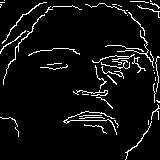

In [18]:
edge = cv2.Canny(i2, 50,130)
cv2_imshow(edge)

In [16]:
train_fns[0]

'/gdrive/My Drive/fake.mp4'

In [31]:
    #for videoname in train_fns : # 하나의 동영상 이름 가져오기
    videoname = train_fns[0]
    frames = []
    is_fake = 1
    if videoname.startswith("/gdrive/My Drive/fake"):
      is_fake = 0

    for i in range(100) :      # 가져온 동영상 얼굴 사진들로 프레임 생성
      frame = cv2.imread(videoname+'image_'+str(i)+'.jpg')
      frames.append(frame)

    resfile = open(videoname+"_result.csv", "a")
    resfile.write("mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,matrix_diff_r,matrix_diff_g,matrix_diff_b, totalentropy, totalvariance, edgedensity, edgenoise, edgeentropy, dctcoefficient,deepfake\n")

    for i in range(len(frames)-1) :
        img1 = frames[i] # 첫 프레임
        img2 = frames[i+1] #다음 프레임

        mse = np.sum((img1.astype("float") - img2.astype("float")) ** 2) #MSE
        mse /= float(img1.shape[0] * img1.shape[1])

        psnr = cv2.PSNR(img1, img2) # 프레임 간 PSNR값

        ssim = measure.compare_ssim(img1, img2,multichannel=True) # SSIM 멀티채널 오픈필요

        histogram_diff = get_image_difference(img1,img2) # 프레임간 히스토그램 차이

        rgb_diff = abs(calcRGBCenter(img2) - calcRGBCenter(img1))

        hsv_diff = abs(calcHSVCenter(img2) - calcHSVCenter(img1))

        matrix_diff = abs(calcMatrixMean(img2) - calcMatrixMean(img1))

        coefficient_diff = abs(dctCoefficient(img2)[0][0] - dctCoefficient(img1)[0][0])

        entropy_diff = abs(totalEntropy(img2) - totalEntropy(img1))

        variance_diff = abs(totalVariance(img2) - totalVariance(img1))

        edgedentsity_diff = abs(edgeDensityAnalysis(img2) - edgeDensityAnalysis(img1))


        edgenoise_diff = abs(edgeNoiseAnalysis(img2) - edgeNoiseAnalysis(img1))

     

        edgeentropy_diff = abs(edgeEntropy(img2) - edgeEntropy(img1))

        resfile.write(
            str(mse) + ',' + str(psnr) + ',' + str(ssim) + ',' + str(histogram_diff) + ',' +
            str(rgb_diff[0]) + ',' + str(rgb_diff[1]) + ',' + str(rgb_diff[2]) + ',' +
            str(hsv_diff[0]) + ',' + str(hsv_diff[1]) + ',' + str(hsv_diff[2]) + ',' +
            str(matrix_diff[0]) + ',' + str(matrix_diff[1]) + ',' + str(matrix_diff[2]) + ',' + str(entropy_diff) + ',' + str(variance_diff) + ',' +
            str(edgedentsity_diff) + ',' + str(edgenoise_diff) + ',' + str(edgeentropy_diff) + ',' + str(coefficient_diff) + ','+ str(is_fake) + '\n'
        )



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24

In [42]:
REAL = pd.read_csv('/gdrive/MyDrive/real.mp4_result.csv')
FAKE = pd.read_csv('/gdrive/MyDrive/fake.mp4_result.csv')
REAL.head()

,mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,matrix_diff_r,matrix_diff_g,matrix_diff_b,totalentropy,totalvariance,edgedensity,edgenoise,edgeentropy,dctcoefficient,deepfake
0,262.370703125,28.712862764292552,0.8978633016723356,0.043835488940160025,0.8685937499951564,0.6790234375014421,0.47730468749796273,0.13457031249970441,0.09410156250021373,0.9145703125022919,0.0073046875,0.0009765625,0.0014062500000000004,0.025993783231480272,23.548507112234574,0.2500000000000009,3.2270845823974668,0.016790635787736874,114,1
1,200.0739453125,29.89011079393905,0.9018890264385093,0.04714269138080798,0.21312499999812928,0.2430859374990746,0.1723437499987739,0.444999999999947,0.3595312499998613,0.02277343750333216,0.00765625,0.0030859375,0.0031249999999999997,0.0440587016025864,31.36378025676413,0.3164062500000009,4.4983323349529485,0.019245432957024855,16,1
2,891.9691015625,23.398518052174193,0.7556750965928994,0.04989355770298559,0.8638671875012847,0.17527343750086288,0.6520703125000153,0.6233984374996808,0.5082812499998113,0.6540624999974938,0.0079296875,0.0047265625,0.006132812499999999,0.021206700879703888,2.688323930252409,0.81640625,5.634946222692193,0.027378505428831634,185,1
3,1006.72296875,22.872916382768842,0.7635000088523277,0.047444256353506964,1.156445312498505,0.1795312500007924,0.5286328125024795,0.3721484375006039,0.05675781250043599,0.8081250000017093,0.0013671874999999986,0.0004687500000000004,0.0035546874999999997,0.03654325134675229,13.086913610740794,1.234375,6.514156042983274,0.03359857774124614,83,1
4,207.256328125,29.73693815917437,0.8942739600804798,0.0435547230334519,0.31632812500033936,0.21496093750035072,0.2500390624972084,0.11808593749937302,0.2233203124998937,0.3319921874959846,3.906249999999917e-05,0.005039062499999999,0.0036718750000000002,0.02452569688108852,15.059164904755107,0.6796875,6.896945464257286,0.017466789249172,40,1


In [40]:
REAL.mean()

Series([], dtype: float64)

In [34]:
FAKE.mean()

mse                725.975178
psnr                31.756990
ssim                 0.771314
hist_diff            0.060635
r_diff               1.824142
g_diff               1.116223
b_diff               1.048626
h_diff               0.643826
s_diff               0.678161
v_diff               1.796061
matrix_diff_r        0.003147
matrix_diff_g        0.003199
matrix_diff_b        0.002960
 totalentropy        0.030182
 totalvariance      61.258960
 edgedensity         0.608467
 edgenoise           5.018860
 edgeentropy         0.021308
 dctcoefficient    115.050505
deepfake             0.000000
dtype: float64

In [37]:
FAKE.describe()

,mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,matrix_diff_r,matrix_diff_g,matrix_diff_b,totalentropy,totalvariance,edgedensity,edgenoise,edgeentropy,dctcoefficient,deepfake
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0
mean,725.975178,31.756990,0.771314,0.060635,1.824142,1.116223,1.048626,0.643826,0.678161,1.796061,0.003147,0.003199,0.002960,0.030182,61.258960,0.608467,5.018860,0.021308,115.050505,0.0
std,441.441478,47.620370,0.098711,0.012689,1.469976,0.852953,0.823303,0.476198,0.609355,1.440220,0.002262,0.002064,0.002480,0.024300,52.411242,0.445602,4.128998,0.014898,75.212539,0.0
min,0.000000,18.821444,0.528466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,414.422344,22.863322,0.698974,0.055525,0.510625,0.451191,0.388613,0.257715,0.238027,0.500430,0.001445,0.001504,0.001035,0.009918,18.242423,0.273437,1.935605,0.009864,55.500000,0.0
50%,608.633477,25.058458,0.775875,0.060603,1.358477,0.815469,0.773281,0.582266,0.452813,1.381914,0.002852,0.003320,0.002031,0.024634,49.218158,0.562500,3.841060,0.020245,118.000000,0.0
75%,1009.088496,26.728091,0.842160,0.066190,2.970137,1.641289,1.652520,0.894336,0.987988,2.907598,0.004297,0.004551,0.004434,0.046806,99.930857,0.845703,7.698098,0.029775,165.500000,0.0
max,2558.923086,361.201999,1.000000,0.088132,5.371953,3.304961,3.323867,1.987500,2.386719,5.303281,0.009687,0.009219,0.009492,0.089611,239.418005,2.234375,19.008662,0.064522,253.000000,0.0


In [38]:
REAL.describe()

,mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,matrix_diff_r,matrix_diff_g,matrix_diff_b,totalentropy,totalvariance,edgedensity,edgenoise,edgeentropy,dctcoefficient,deepfake
count,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199
unique,100,100,100,100,100,100,100,100,100,100,95,88,87,100,100,95,100,100,89,2
top,590.286015625,18.43837769854635,0.9117167579711755,0.06712224711102036,3.5364453124992963,0.21496093750035072,0.4028906249995856,1.1948437500010591,0.49472656249980673,2.6914062500000853,0.00765625,0.0009765625,0.0035546875,0.01686179311411795,115.39458046726509,0.12109374999999911,8.900077610406527,0.007609110055112334,206,1
freq,2,2,2,2,2,2,2,2,2,2,4,6,6,2,2,4,2,2,6,198


In [43]:
FAKE.corr()

,mse,psnr,ssim,hist_diff,r_diff,g_diff,b_diff,h_diff,s_diff,v_diff,matrix_diff_r,matrix_diff_g,matrix_diff_b,totalentropy,totalvariance,edgedensity,edgenoise,edgeentropy,dctcoefficient,deepfake
mse,1.000000,-0.287749,-0.924003,0.428628,0.659170,0.606441,0.616534,0.192473,0.529060,0.659191,0.165504,0.096320,0.046090,0.514650,0.513905,0.362544,0.256611,0.464201,0.262897,NaN
psnr,-0.287749,1.000000,0.383414,-0.702470,-0.214883,-0.223042,-0.217275,-0.202879,-0.187284,-0.215787,-0.207102,-0.224549,-0.173213,-0.206672,-0.194617,-0.213054,-0.183784,-0.229152,-0.231303,NaN
ssim,-0.924003,0.383414,1.000000,-0.446745,-0.676292,-0.644046,-0.638227,-0.192052,-0.488555,-0.676379,-0.173588,-0.154169,-0.113981,-0.518983,-0.482881,-0.372416,-0.199371,-0.485254,-0.267365,NaN
hist_diff,0.428628,-0.702470,-0.446745,1.000000,0.422748,0.356783,0.379767,0.283659,0.341890,0.419881,0.084557,0.228872,0.161524,0.441137,0.419414,0.455724,0.240352,0.496759,0.277942,NaN
r_diff,0.659170,-0.214883,-0.676292,0.422748,1.000000,0.928961,0.922619,0.216734,0.534980,0.999477,0.071168,0.096280,0.177837,0.821254,0.773243,0.344800,0.221371,0.427618,0.192569,NaN
g_diff,0.606441,-0.223042,-0.644046,0.356783,0.928961,1.000000,0.931885,0.187022,0.401485,0.932962,0.054699,0.093005,0.128243,0.700830,0.710237,0.223550,0.129036,0.317828,0.155683,NaN
b_diff,0.616534,-0.217275,-0.638227,0.379767,0.922619,0.931885,1.000000,0.149629,0.284185,0.925106,-0.000312,0.103693,0.157342,0.641671,0.693190,0.296315,0.212905,0.388543,0.129674,NaN
h_diff,0.192473,-0.202879,-0.192052,0.283659,0.216734,0.187022,0.149629,1.000000,0.238880,0.214940,-0.035523,0.075296,0.001980,0.289130,0.260850,0.189854,0.179274,0.217023,0.101787,NaN
s_diff,0.529060,-0.187284,-0.488555,0.341890,0.534980,0.401485,0.284185,0.238880,1.000000,0.534723,0.244325,0.030491,0.050268,0.678944,0.454563,0.330144,0.094528,0.276517,0.168067,NaN
v_diff,0.659191,-0.215787,-0.676379,0.419881,0.999477,0.932962,0.925106,0.214940,0.534723,1.000000,0.074743,0.090154,0.181684,0.819748,0.773540,0.349010,0.224806,0.426993,0.198304,NaN


In [45]:
REAL.corr()

""


In [68]:
im = cv2.imread('/gdrive/MyDrive/fake.mp4image_0.jpg')
auto_canny(im[0][0][0])

TypeError: ignored